In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import tensorflow as tf

pd.options.display.max_columns = None

In [154]:
df_covid = pd.read_csv('./Covid_clean.csv')

C:\Users\ismael\AppData\Local\Temp\ipykernel_3276\3510291388.py:1: DtypeWarning: Columns (4,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covid = pd.read_csv('./Covid_clean.csv')


Contenido del Dataset


The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- sex: 1 for female and 2 for male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
- degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease: whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- tobacco: whether the patient is a tobacco user.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.
- fallecidos: 1 for yes and 2 for no.

# Rebalanceo 
## submuestreo

In [171]:
clase_mayoritaria = df_covid[df_covid['fallecidos'] == 0]
clase_minoritaria = df_covid[df_covid['fallecidos'] == 1]

clase_mayoritarial_downsampled = resample(clase_mayoritaria,
                                            replace = False,
                                            n_samples = len(clase_minoritaria),
                                            random_state = 42)

df_covid_downsampled = pd.concat([clase_mayoritarial_downsampled, clase_minoritaria])

df_covid_downsampled['fallecidos'].value_counts()

fallecidos
0    74612
1    74612
Name: count, dtype: int64

In [172]:
# creamos el modelo de clasificacion

features = ['SEX', 'PNEUMONIA', 'AGE', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']
target = 'fallecidos'

X = df_covid_downsampled[features]
y = df_covid_downsampled[target]



# random forest

In [173]:
# dividimos el dataset en train y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Entrenamos un modelo de random forest con 100 arboles y evaluamos

In [174]:
# entrenamos el modelo

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

Evaluamos

In [175]:

# predecimos

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)
precision = precision_score(y_test, y_pred, average='weighted')

print('Precision: ', precision)
recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: ', recall)
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1: ', f1)


Accuracy:  0.846171888088457
Precision:  0.8462302328230289
Recall:  0.846171888088457
F1:  0.846163433154226


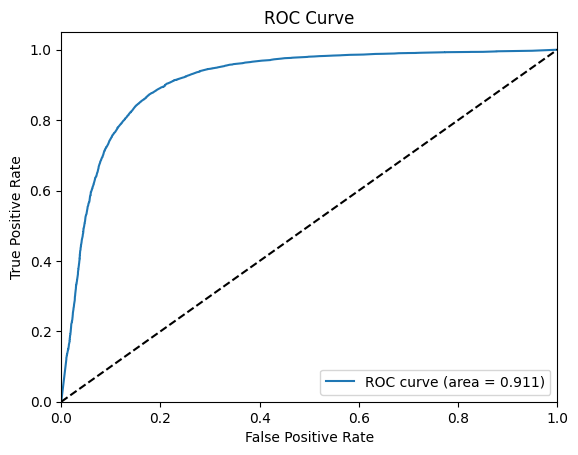

In [176]:
# curva roc

y_pred_proba = rf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)



plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred_proba))

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.legend(loc="lower right")

plt.show()


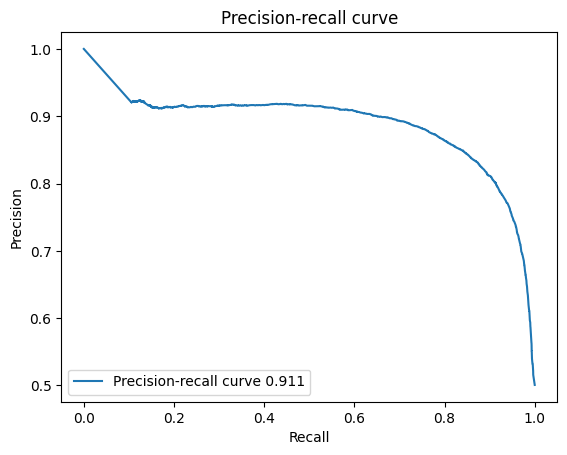

In [177]:
# curva precision recall

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision, label='Precision-recall curve %0.3f' % roc_auc_score(y_test, y_pred_proba))

plt.xlabel('Recall')

plt.ylabel('Precision')

plt.title('Precision-recall curve')

plt.legend(loc="lower left")

plt.show()

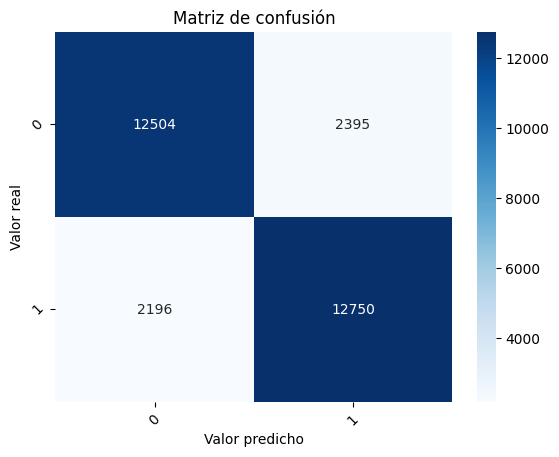

In [178]:
#creamos matriz de confusion

cm = confusion_matrix(y_test, y_pred)

#creamos el heatmap

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matriz de confusión')


plt.xticks(rotation=45)

plt.yticks(rotation=45)


plt.xlabel('Valor predicho')

plt.ylabel('Valor real')

plt.show()

Vemos la importancia de cada variable

In [180]:
# vemos la importancia de las variables

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print(importances)

                importance
feature                   
PNEUMONIA            0.440
AGE                  0.367
DIABETES             0.058
HIPERTENSION         0.053
SEX                  0.022
RENAL_CHRONIC        0.014
OBESITY              0.009
COPD                 0.008
OTHER_DISEASE        0.008
INMSUPR              0.006
CARDIOVASCULAR       0.006
TOBACCO              0.005
ASTHMA               0.004


Hacemos un grafico de la importancia de cada variable en el modelo para comprender que variables es mas importante para el modelo y para el resultado buscado. 

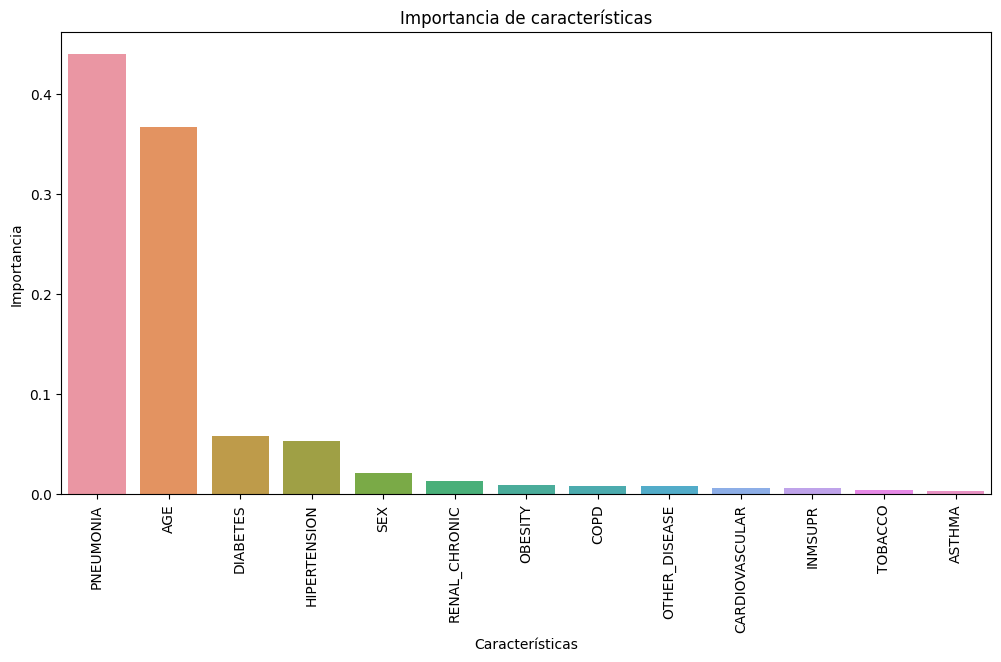

In [181]:
# Obtener los valores de importancia de características y sus nombres

feature_importances = rf.feature_importances_
feature_names = X_train.columns

# Crear un dataframe con los valores de importancia de características y sus nombres

feature_importances_df = pd.DataFrame({'feature_importances': feature_importances,
                                        'feature_names': feature_names})

# Ordenar los valores de importancia de características de mayor a menor

feature_importances_df.sort_values('feature_importances', ascending=False, inplace=True)

# Crear un gráfico de barras con los valores de importancia de características

plt.figure(figsize=(12, 6))

sns.barplot(x=feature_importances_df.feature_names, y=feature_importances_df.feature_importances)

plt.title('Importancia de características')

plt.xlabel('Características')

plt.ylabel('Importancia')

plt.xticks(rotation=90)

plt.show()

Matriz de confusion

#### Conclusiones:

 

- Random Forest resamplea/rebalanceado
    
    Accuracy:  0.846171888088457

    Precision:  0.8462302328230289

    Recall:  0.846171888088457

    F1:  0.846163433154226
    
    